In [1]:
import numpy as np 
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sn

# Загрузка и предобработка данных

In [2]:
def to_categorical(label_array, count_number=2):
    """Пердставить лейбал в виде массива со значением"""
    label_array = np.array(label_array) 
    n = label_array.shape[0]
    categorical = np.zeros((n, count_number))
    categorical[np.arange(n), label_array] = 1
    return categorical


In [3]:
def load_data():
    """Загрузка датасета"""
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    train_filter = np.where((Y_train == 0 ) | (Y_train == 1))
    test_filter = np.where((Y_test == 0) | (Y_test == 1))
    X_train, Y_train = X_train[train_filter], Y_train[train_filter]
    X_test, Y_test = X_test[test_filter], Y_test[test_filter]

    # преобразование в 1 канал
    X_train = X_train.reshape((X_train.shape[0], 28, 28))/255.
    X_test = X_test.reshape((X_test.shape[0], 28, 28))/255.

    # перевод в one hot encoder
    Y_train = to_categorical(Y_train)
    Y_test = to_categorical(Y_test)

    return (X_train.round(), Y_train), (X_test.round(), Y_test)

In [4]:
(train_X, train_Y), (test_X, test_Y) = load_data()

In [5]:
len(train_X)

12665

In [6]:
train_X[1].max()

1.0

In [7]:
train_Y[:10]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

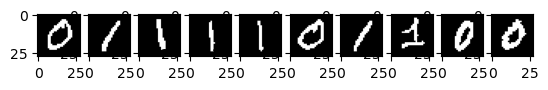

In [8]:
f  = plt.figure()
for i, image  in enumerate(train_X[:10]):
    f.add_subplot(1,10, i+1)
    plt.imshow(image, cmap="gray")
plt.show()

## Генетический алгоритм 


In [9]:
import random

In [10]:
import tensorflow as tf

In [45]:
class Individual(list):
    def __init__(self, *args):
        super().__init__(*args)
        self.fitness = FitnessMax()


class FitnessMax:
    def __init__(self):
        self.values = [0]


"""
Индивид - состоит из 784 хромосом
Хромосома состоит из 2 генов 
"""

class GA:
    def __init__(self,
                 size_population,
                 mutation,
                 max_generation,
                 crossover_per=1):

        self.max_generation = max_generation
        self.mutation = mutation
        self.crossover_per = crossover_per
        self.size_population = size_population
        self.count_chrom = 28*28
        self.len_chrom = 2

        self.maxFitnessValues = []
        self.meanFitnessValues = []
        self.best_ind = []
        self.population = []
        self.generationCounter = 0
        self.list_population = []
        self.statistics_generation = []
        self.loss = []
        self.checkStep = 0
        self.log_step = ''

    def chrom_create(self):
        return np.random.uniform(-1, 1, size=2)

    def individual_create(self):
        """Генерация индивидуума"""
        return Individual([[self.chrom_create() for _ in range(self.count_chrom)]])

    def population_create(self):
        """ Создание популяции"""
        return list([self.individual_create() for _ in range(self.size_population)])

    def fitness(self,input, y_true,  individual: Individual):
        """Функция приспособленности"""
        
        def accuracy(y_pred, y_true):
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            return (y_pred==y_true).sum()/y_true.size
    
        y_true = []
        y_pred = []
        for x, y in zip(test_X,test_Y):
            output = np.dot(x.flatten(), individual[0])
            y_true.append(np.argmax(y))
            y_pred.append(np.argmax(output)) 
        
        return accuracy(y_pred, y_true)


    
    @staticmethod
    def __clone(value):
        """Клонирование индивидуума"""
        ind = Individual(value[:])
        ind.fitness.values = value.fitness.values
        return ind

    @staticmethod
    def selTournament(population, p_len):
        offspring = []
        for n in range(p_len):
            i1 = i2 = i3 = 0
            while i1 == i2 or i1 == i3 or i2 == i3:
                i1, i2, i3 = random.randint(0, p_len - 1), random.randint(0, p_len - 1), random.randint(0, p_len - 1)

            offspring.append(
                max([population[i1], population[i2], population[i3]], key=lambda ind: ind.fitness.values))

        return offspring     

    @staticmethod
    def mutator( mutant):
        """Мутация """
        for chromosomes in mutant[0]:
            random_gen = random.randint(0, 1)
            chromosomes[random_gen] = random.triangular(-0.5, 0.5, random.gauss(0, 0.5))
            
    def crossover(self, p1, p2):
        """Скрещивание"""
        children_1 = []
        children_2 = []
        
        for chrom_1, chrom_2 in zip(p1[0], p2[0]):
            
            new_chrom_1 = []
            new_chrom_2 = []
            for gen_1, gen_2 in zip(chrom_1, chrom_2):
                if gen_1<gen_2:
                    new_chrom_1.append(np.array(np.random.uniform(gen_1, gen_2, size=1)[0]))
                    new_chrom_2.append(np.array(np.random.uniform(gen_1, gen_2, size=1)[0]))

                else:
                    new_chrom_1.append(np.array(np.random.uniform(gen_2, gen_1, size=1)[0]))
                    new_chrom_2.append(np.array(np.random.uniform(gen_2, gen_1, size=1)[0]))
                    
            children_1.append(np.array(new_chrom_1))
            children_2.append(np.array(new_chrom_2))
        return Individual([children_1]), Individual([children_2])

    def createGA(self):
        """Создание начальной популяции"""
        print(f"--------<Генерация 1 поколения>-------")
        self.population = self.population_create()
        self.generationCounter = 0
        # fitnessValues = list(map(lambda x: self.fitness(self.inputs, self.y_true, x), self.population))

    def TrainGA(self, inputs, label):
        """Обучение"""
        self.inputs = inputs
        self.label = label
        generationCounter = self.generationCounter
        population = self.population
        print(f"--------<Рассчет  fitness>-------")
        FitnessValues = list(map(lambda x: self.fitness(self.inputs, self.label, x), population))

        for individual, fitnessValue in zip(population, FitnessValues):
            individual.fitness.values = fitnessValue
 
        while generationCounter < self.max_generation:
            # self.list_population.append(population)
            
            generationCounter += 1
            print(f"--------<Поколение {generationCounter}>-------")
            # Отбор 
            offspring = self.selTournament(population, len(population))
            offspring = list(map(self.__clone, offspring))

            new_offspring = []
            # скрещивание 
            print(f"--------<Скрещивание>-------") 
            for parent1, parent2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.crossover_per:
                    child1, child2 = self.crossover(parent1, parent2)
                    new_offspring.append(child1)
                    new_offspring.append(child2)
                else:
                    new_offspring.append(parent1)
                    new_offspring.append(parent2)

            offspring = new_offspring.copy()
            # Мутация
            print(f"--------<Мутация>-------") 
            for mutant in offspring:
                if random.random() < self.mutation:
                    self.mutator(mutant)

            freshFitnessValues = list(map(lambda x: self.fitness(self.inputs, self.label, x), offspring))

            # расчет показателей
            for individual, fitnessValue in zip(offspring, freshFitnessValues):
                individual.fitness.values = fitnessValue
            population[:] = offspring
            fitnessValues = [ind.fitness.values for ind in population]
            maxFitness = max(fitnessValues)
            meanFitness = sum(fitnessValues) / len(population)
            self.maxFitnessValues.append(maxFitness)
            self.meanFitnessValues.append(meanFitness)
            
            best_index = fitnessValues.index(max(fitnessValues))
            self.best_ind = population[best_index]
        self.population = population
        self.generationCounter = 0
        return self.best_ind



# Персептрон 

In [46]:
class Perceptron:
    """Класс для перцептрона"""
    def __init__ (self, input_shape, output_shape ,ga_parms,epochs =1):
        # Xavier 
        stdv = 1/np.sqrt(input_shape)
        self.W = np.random.uniform(-stdv, stdv, size=(input_shape, output_shape))
        self.b = np.random.uniform(-stdv, stdv, size=output_shape)
        self.epochs = epochs
        self.activate=0
        self.ga= GA(*ga_parms)
        self.get_csv(self.W, "start_W")
    

    def get_csv(self, array, name):
        np.savetxt(f"E:\GitHub\Mag_2_semester\DoIS\LW_4\weights\{name}.csv", array, delimiter=",")

    #функции активации 
    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    # формирование весов  
    def forward(self, input, activate ):
        
        self.output = np.dot(input, self.W)
        self.output += self.b 
        
        return self.output   

    # Обучение 
    def train(self, X, Y, count_data = 1000, save_itr =  True ):
        self.ga.createGA()
        for epoch in range(self.epochs):
            for i in range(len(X[:count_data])):
                self.W = self.ga.TrainGA(X[i].flatten(),Y[i])[0]
                if save_itr:
                    self.get_csv(self.W , f"epoch_{epoch}_{i}")
            self.get_csv(self.W , f"epoch_{epoch}")

    # пердсказание
    def pred(self, image):
        x = image.flatten()   
        y_pred = self.forward(x, self.activate)
        return np.argmax(y_pred)      
    

**Тест**

In [55]:
# создание и обучение
perceptron = Perceptron(28*28,2,(50, 0.3, 5, 1))
perceptron.train(train_X, train_Y, count_data = 15)

--------<Генерация 1 поколения>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 5>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 5>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------


## Статистика

In [47]:
def stat(perceptron_: Perceptron):
    def confusion_matrix(y_pred, y_true):

        classes = np.unique(y_true)
        classes.sort()
        conf_m = np.zeros(shape=(len(classes), len(classes)))
        for i in classes:
            for j in classes:
                conf_m[i, j] = np.logical_and((y_pred==i), (y_true==j)).sum()
        return conf_m, classes
    
    def accuracy(y_pred, y_true):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        return (y_pred==y_true).sum()/y_true.size
    
    y_true = []
    y_pred = []
    for x, y in zip(train_X,train_Y):
        y_true.append(np.argmax(y))
        y_pred.append(perceptron_.pred(x)) 
        
    confusion_matrix = confusion_matrix(y_pred,y_true)
    print("Accuracy:",accuracy(y_pred, y_true)*100)
    df_cm = pd.DataFrame(confusion_matrix[0], range(2), range(2))

    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='g',cmap="Greens") # font size
    plt.show()

    graph = perceptron_.ga.meanFitnessValues
    step = perceptron_.ga.max_generation
    plt.grid(False)
    plt.plot(np.arange(len(graph)), graph, linewidth= 2)
    for i in range(16):    
        plt.axvline(x=i*step, color = 'r', linewidth= 0.5)
    plt.show()

In [48]:
def view_weigts(perceptron_:Perceptron):
    f  = plt.figure(figsize=(20,20))
    for size, i in enumerate(np.array(perceptron_.W).T):
        f.add_subplot(5,5, size+1)
        plt.grid(False)
        plt.imshow(i.reshape((28,28)), cmap='gray')
    
    plt.show()

# Тесты

In [49]:
test_1 = {"count_ind":[50, 50, 50], "per_mut":[0.1, 0.5, 1], "count_gen":[5, 5, 5],"per_cross":[1, 1, 1], "count_data": [15,15,15], "epochs": [1,1,1]}
test_2 = {"count_ind":[50, 50, 50], "per_mut":[0.1, 0.1, 0.1], "count_gen":[5, 5, 5],"per_cross":[0.3, 0.6, 0.9], "count_data": [15,15,15], "epochs": [1,1,1]}
test_3 = {"count_ind":[50, 50, 50], "per_mut":[0.1, 0.1, 0.1], "count_gen":[10, 15, 20],"per_cross":[1, 1, 1], "count_data": [15,15,15], "epochs": [1,1,1]}
test_4 = {"count_ind":[10, 20, 100], "per_mut":[0.1, 0.1, 0.1], "count_gen":[5, 5, 5],"per_cross":[1, 1, 1], "count_data": [15,15,15], "epochs": [1,1,1]}


In [50]:
def get_test(test):

    for i in range(len(test['count_ind'])):
        print("Кол-во индивид.:", test['count_ind'][i])
        print("Кол-во поколений:", test['count_gen'][i])
        print("Вероятность мутации:", test['per_mut'][i])
        print("Вероятность кроссовера:", test['per_cross'][i])

        print("Кол-во обучающих данных:", test['count_data'][i])
        print("Кол-во эпох:", test['epochs'][i])

        par_ga = [test['count_ind'][i],  test['per_mut'][i], test['count_gen'][i], test['per_cross'][i]]

        perceptron_1 = Perceptron(28*28,2,par_ga, test['epochs'][i])
        perceptron_1.train(train_X,train_Y,test["count_data"][i])
        stat(perceptron_1)
        view_weigts(perceptron_1)

    

Кол-во индивид.: 50
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
--------<Генерация 1 поколения>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 5>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Пок

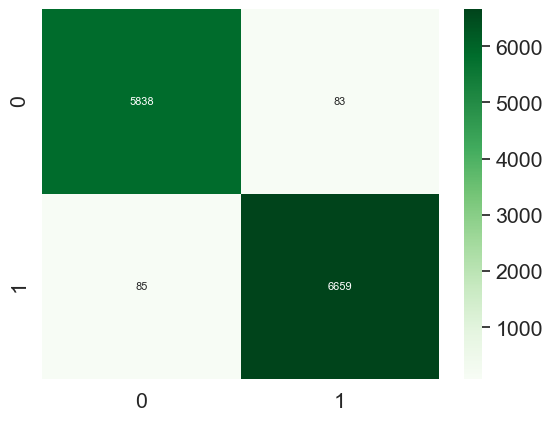

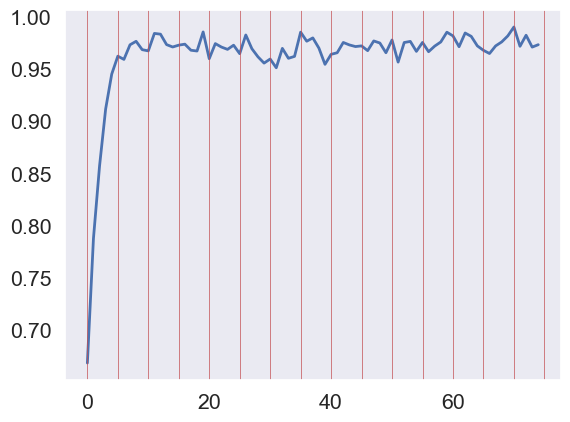

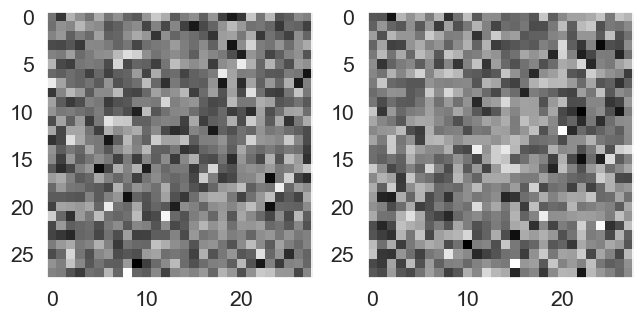

Кол-во индивид.: 50
Кол-во поколений: 5
Вероятность мутации: 0.5
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
--------<Генерация 1 поколения>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 5>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Рассчет  fitness>-------
--------<Поколение 1>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 2>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 3>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Поколение 4>-------
--------<Скрещивание>-------
--------<Мутация>-------
--------<Пок

KeyboardInterrupt: 

In [54]:
get_test(test_1)

Кол-во индивид.: 50
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 0.3
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 59.178839320963284


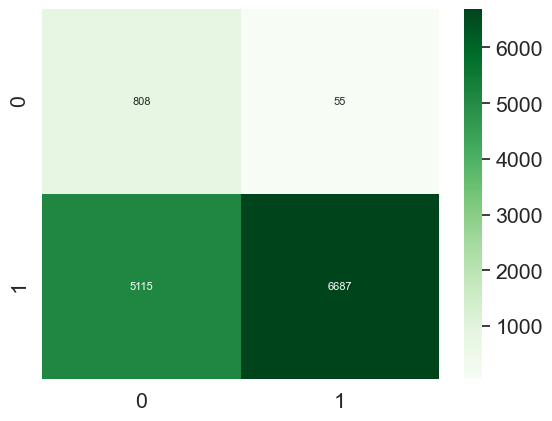

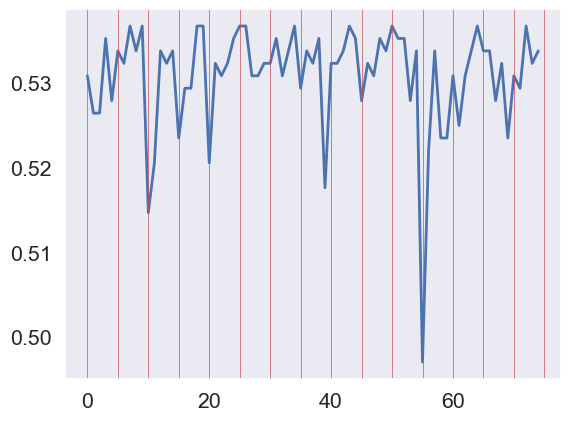

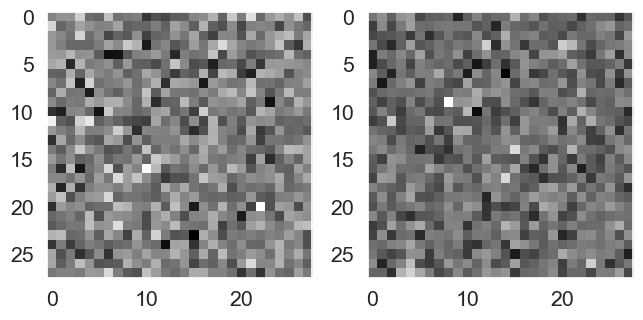

Кол-во индивид.: 50
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 0.6
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 48.09317015396763


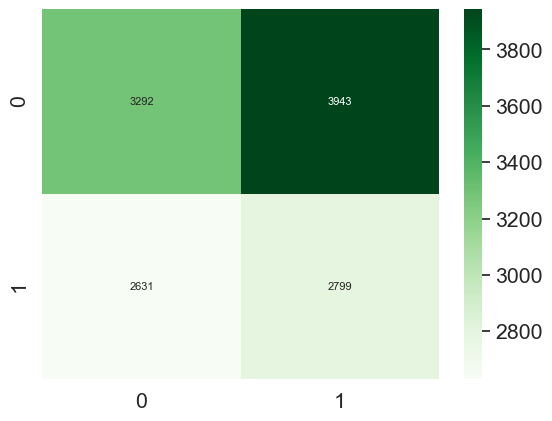

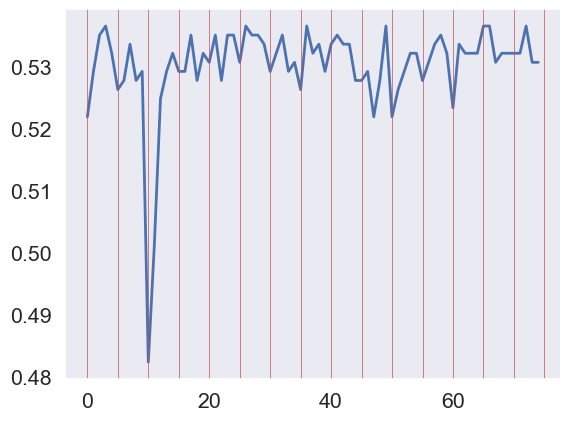

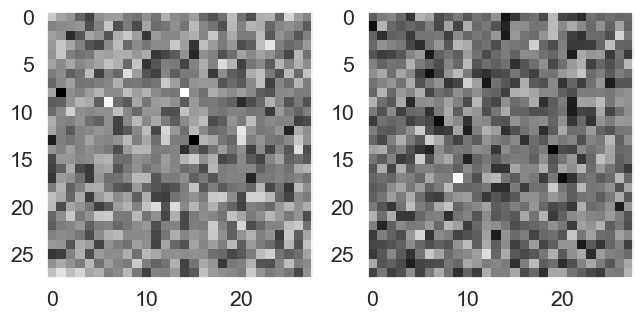

Кол-во индивид.: 50
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 0.9
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 38.81563363600474


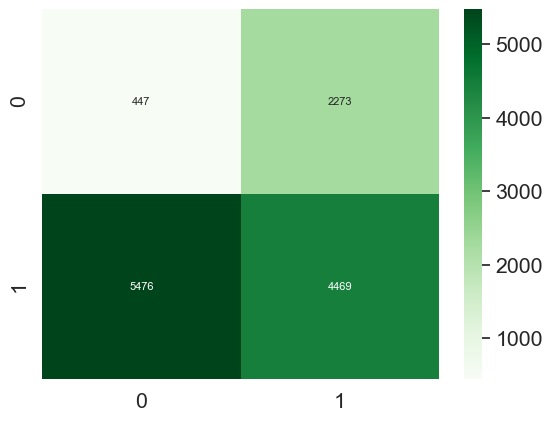

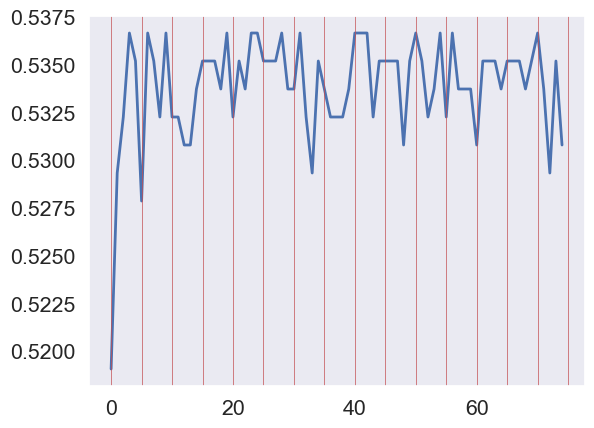

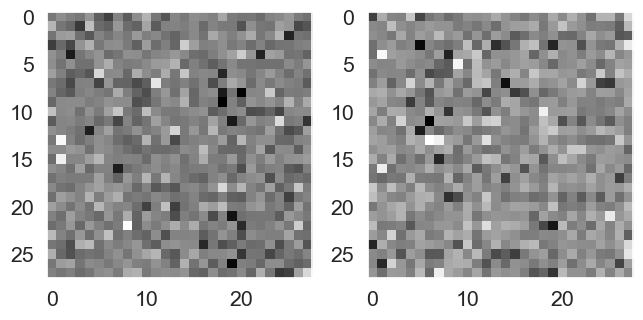

In [19]:
get_test(test_2)

Кол-во индивид.: 50
Кол-во поколений: 10
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 61.55546782471378


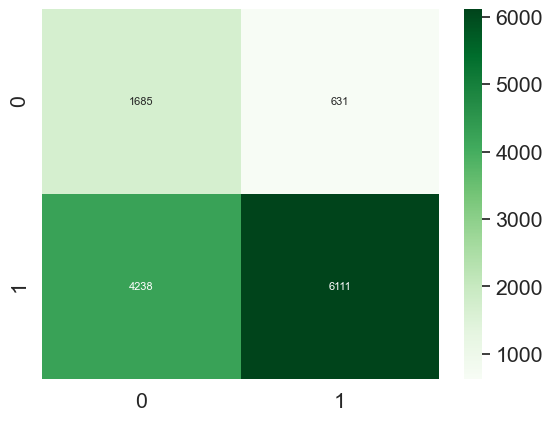

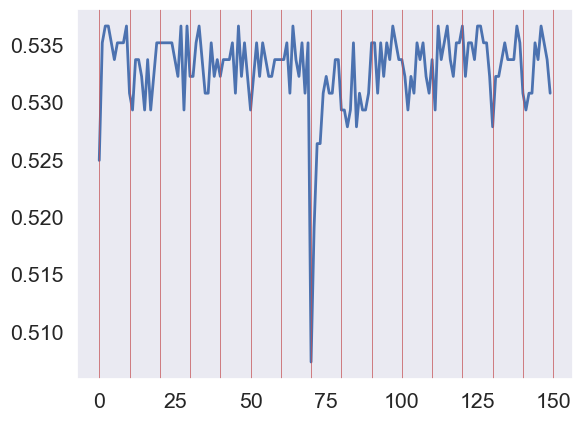

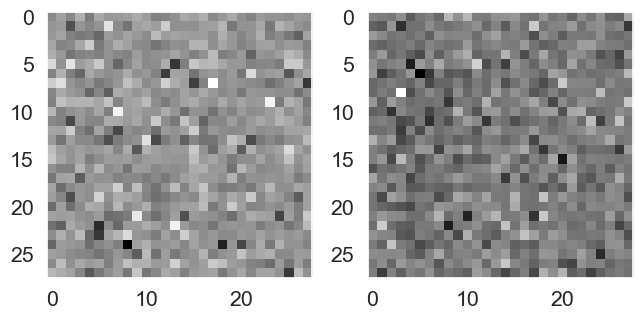

Кол-во индивид.: 50
Кол-во поколений: 15
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 51.90682984603237


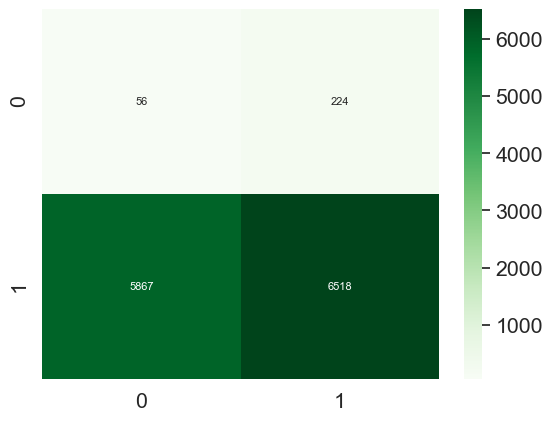

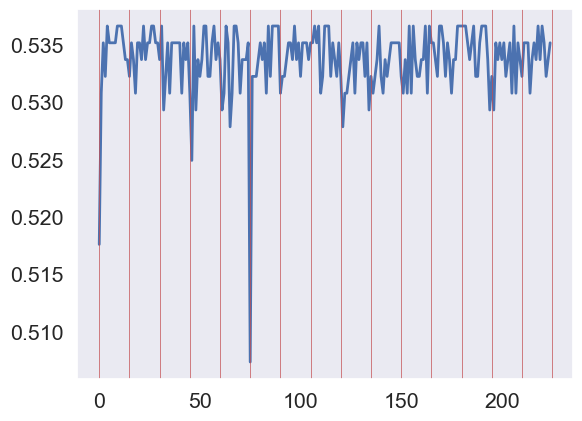

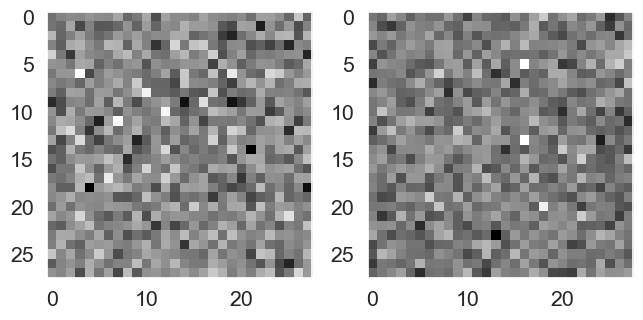

Кол-во индивид.: 50
Кол-во поколений: 20
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 48.06158705092775


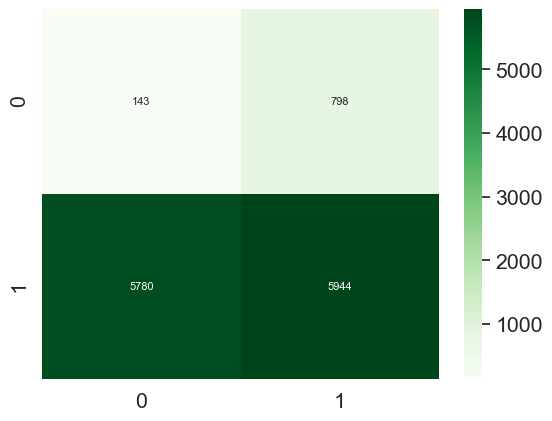

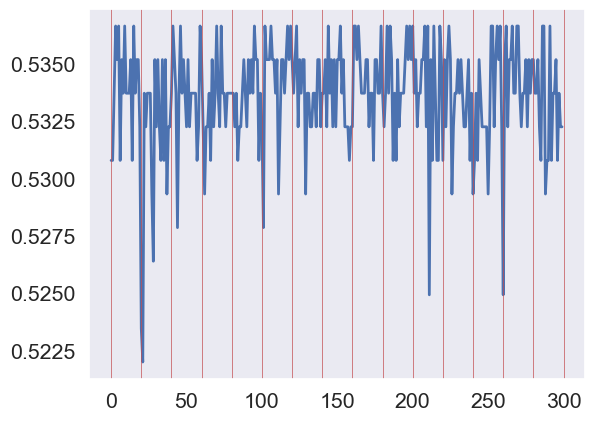

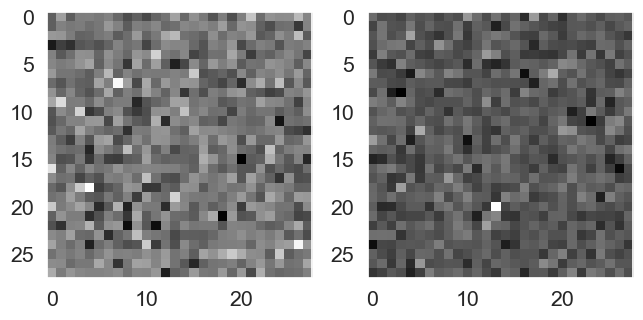

In [20]:
get_test(test_3)

Кол-во индивид.: 10
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 67.43782076589025


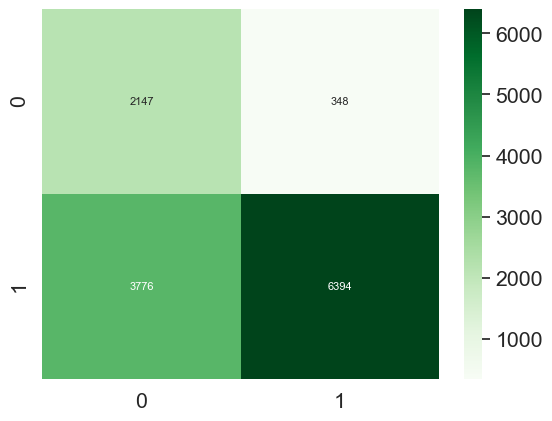

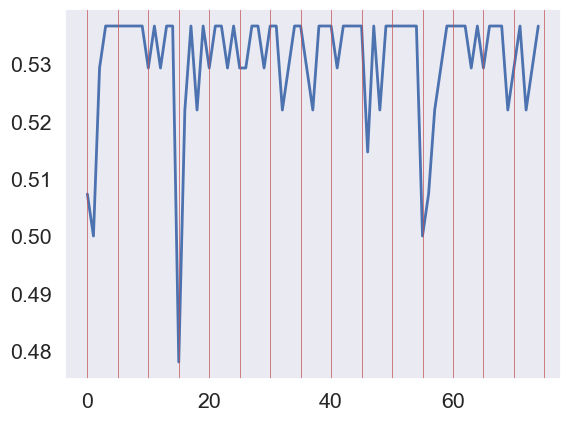

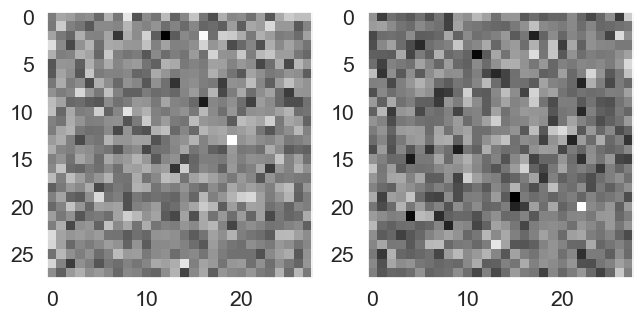

Кол-во индивид.: 20
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 51.930517173312275


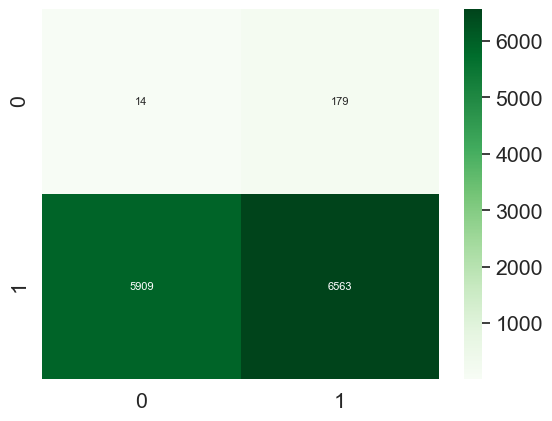

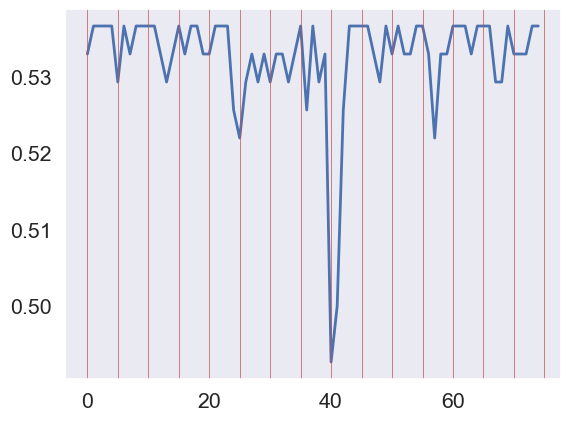

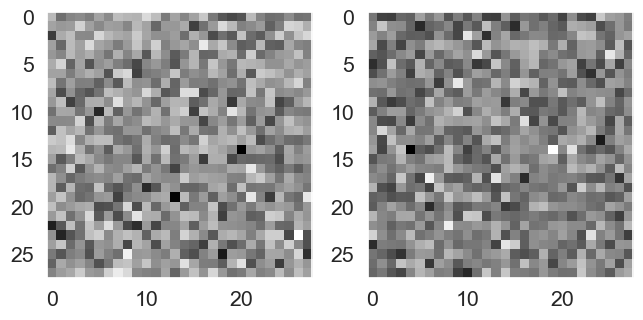

Кол-во индивид.: 100
Кол-во поколений: 5
Вероятность мутации: 0.1
Вероятность кроссовера: 1
Кол-во обучающих данных: 15
Кол-во эпох: 1
Accuracy: 54.04658507698381


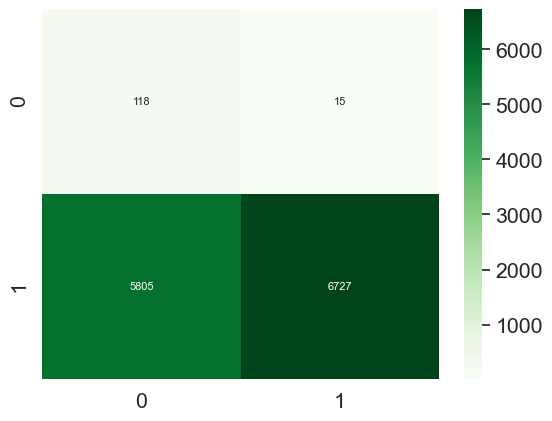

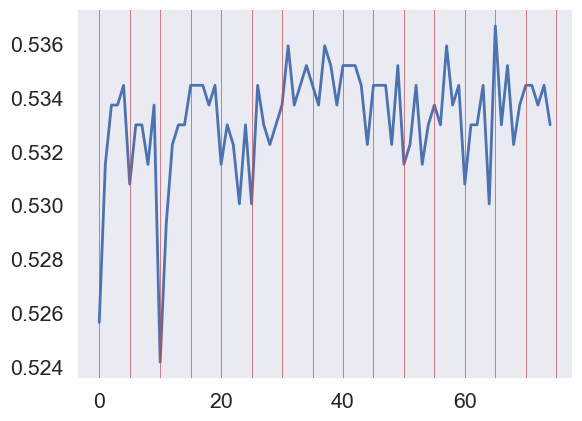

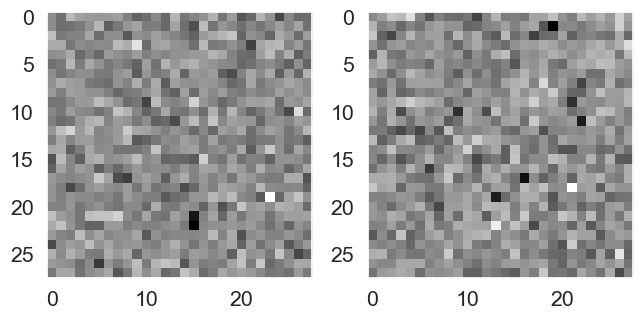

In [21]:
get_test(test_4)